In [7]:
# import os
# import re
# import pandas as pd
# import pyarrow as pa
# import pyarrow.parquet as pq

# # Function to log folder structure into a Parquet file
# def log_folder_to_parquet(base_folder, parquet_file):
#     # Regex to match date format yyyy_mm_dd
#     date_pattern = re.compile(r"\d{4}_\d{2}_\d{2}")
    
#     # Data storage for DataFrame
#     log_data = []
    
#     # Traverse the base folder
#     for folder_name in os.listdir(base_folder):
#         folder_path = os.path.join(base_folder, folder_name)
        
#         # Check if the folder name matches the date pattern
#         if os.path.isdir(folder_path) and date_pattern.match(folder_name):
#             calib_status = 'NO'
#             rec_status = 'NO'
#             calib_files = []
#             rec_files = []
            
#             # Check for calibration files starting with 'calib'
#             for file_name in os.listdir(folder_path):
#                 if file_name.startswith("calib"):
#                     calib_status = 'YES'
#                     calib_files.append(file_name)
#             # check for rec
#                 if file_name[0].isdigit():
#                     rec_status = 'YES'
#                     rec_files.append(file_name)
            
#             # Append data to list for DataFrame creation
#             log_data.append({
#                 'date_folder': folder_name,
#                 'calib_status': calib_status,
#                 'calib_files': ', '.join(calib_files),
#                 'folder_path': folder_path,
#                 'rec_status': rec_status,
#                 'rec_files': ', '.join(rec_files)
                
#             })
    
#     # Create DataFrame and save as Parquet file
#     df = pd.DataFrame(log_data)
#     table = pa.Table.from_pandas(df)
#     pq.write_table(table, parquet_file)

# if __name__ == "__main__":
#     base_folder = "/home/lq53/mir_data/24summ"  # Replace with your base folder
#     save_path = os.path.join(base_folder, 'paret')
#     if not os.path.exists(save_path):
#         os.makedirs(save_path)
#     parquet_file = os.path.join(save_path, "folder_log.parquet")   # Output Parquet file
#     log_folder_to_parquet(base_folder, parquet_file)


In [26]:
# import pandas as pd
# import pyarrow.parquet as pq
# import os

# # Function to load the Parquet file
# def load_parquet(parquet_file):
#     # Read the Parquet file into a pandas DataFrame
#     table = pq.read_table(parquet_file)
#     df = table.to_pandas()
#     return df

# # Function to display the DataFrame in the notebook
# def display_parquet(parquet_file):
#     df = load_parquet(parquet_file)
    
#     # Display the DataFrame
#     display(df)

# if __name__ == "__main__":
#     base_folder = "/home/lq53/mir_data/24summ"  # Replace with your base folder
#     parquet_file = os.path.join(base_folder, 'paret', 'folder_log.parquet')  # Path to your parquet file
    
#     # Call function to display the Parquet file
#     display_parquet(parquet_file)


In [37]:
import os
import re
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq

# Temporary function for special dates handling
def is_special_date(folder_name):
    # List of special dates where z_adjusted should be 'NO'
    special_dates = ['08_08', '08_16', '08_26', '08_29']
    # Check if the folder name contains one of the special dates
    return any(folder_name.endswith(date) for date in special_dates)

# Function to log folder structure into a Parquet file with hierarchy of rec_files and associated calib_files
def log_folder_to_parquet(base_folder, parquet_file):
    # Regex to match date format yyyy_mm_dd
    date_pattern = re.compile(r"\d{4}_\d{2}_\d{2}")
    
    # Data storage for DataFrame
    log_data = []
    
    # Traverse the base folder
    for folder_name in os.listdir(base_folder):
        folder_path = os.path.join(base_folder, folder_name)
        
        # Check if the folder name matches the date pattern
        if os.path.isdir(folder_path) and date_pattern.match(folder_name):
            rec_files_data = []  # To store rec files and their status
            calib_files = []  # To store calibration files

            # Check for calibration files starting with 'calib'
            for file_name in os.listdir(folder_path):
                if file_name.startswith("calib"):
                    calib_files.append(file_name)

            # Traverse subfolders within this folder
            for subfolder_name in os.listdir(folder_path):
                subfolder_path = os.path.join(folder_path, subfolder_name)
                
                # Check for subfolders starting with a digit (rec folders)
                if os.path.isdir(subfolder_path) and subfolder_name[0].isdigit():
                    # Special date handling for z_adjusted
                    z_adjusted = 'YES' if not is_special_date(folder_name) else 'NO'
                    sync = 'NO'
                    labe_3d_status = 'NO'
                    
                    rec_file_data = {
                        'rec_file': subfolder_name, 
                        'label3d_status': labe_3d_status, 
                        'sync': sync,
                        'z_adjusted': z_adjusted
                    }
                    
                    # Look inside this subfolder for label3d_dannce.mat and df_ files
                    for file_name in os.listdir(subfolder_path):
                        # Check for label3d_dannce.mat in the subfolder
                        if file_name.endswith("label3d_dannce.mat"):
                            rec_file_data['label3d_status'] = 'YES'  # Found label3d_dannce.mat
                        
                        # If the file is further processed (starts with df_)
                        if file_name.startswith("df_") and file_name.endswith("label3d_dannce.mat"):
                            rec_file_data['label3d_status'] = 'YES'  # Processed label3d_dannce.mat
                            rec_file_data['sync'] = 'YES'  # Processed further, so sync is 'YES'
                    
                    # Add the rec_file and its status to the data structure
                    rec_files_data.append(rec_file_data)
            
            # Append data to list for DataFrame creation, including hierarchical structure
            log_data.append({
                'date_folder': folder_name,
                'calib_files': calib_files,  # Store the calibration files under date_folder level
                'rec_files_data': rec_files_data  # Each rec file with its status (label3d_dannce, sync, z_adjusted)
            })
    
    # Create DataFrame and save as Parquet file
    df = pd.json_normalize(log_data, 'rec_files_data', ['date_folder', 'calib_files'])
    table = pa.Table.from_pandas(df)
    pq.write_table(table, parquet_file)

if __name__ == "__main__":
    base_folder = "/home/lq53/mir_data/24summ"  # Replace with your base folder
    save_path = os.path.join(base_folder, 'paret')
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    parquet_file = os.path.join(save_path, "folder_log.parquet")   # Output Parquet file
    log_folder_to_parquet(base_folder, parquet_file)


In [38]:
import pandas as pd
import pyarrow.parquet as pq

# Load the Parquet file into a DataFrame
def load_parquet(parquet_file):
    # Read the parquet file into a pandas DataFrame
    table = pq.read_table(parquet_file)
    df = table.to_pandas()
    return df

# Display the DataFrame
parquet_file = '/home/lq53/mir_data/24summ/paret/folder_log.parquet'  # Adjust the path as needed
df = load_parquet(parquet_file)

# Display the DataFrame in the notebook
# df.head()  # Shows the top rows of the DataFrame
df.head(len(df)) # display all


,rec_file,label3d_status,sync,z_adjusted,date_folder,calib_files
0,20240730_PMCr2,NO,NO,NO,2024_08_26,[calib_before]
1,20240717_PMCr2,NO,NO,NO,2024_08_26,[calib_before]
2,20240717_PMCr1,NO,NO,NO,2024_08_26,[calib_before]
3,1686940_left,YES,YES,YES,2024_06_26,[]
4,1691485RMHBN1425,YES,YES,YES,2024_07_15,[]
5,1691485RMPBF1531,YES,YES,YES,2024_07_15,[]
6,1691485RMPBS1659,YES,YES,YES,2024_07_15,[]
7,1691485RMHBN1405,YES,YES,YES,2024_07_16,[]
8,20240717_PMC_r1_11_50,NO,NO,NO,2024_08_16,"[calib_before_3, calib_before_2, calib_before]"
9,20240717_PMC_r2_11_00,NO,NO,NO,2024_08_16,"[calib_before_3, calib_before_2, calib_before]"


In [17]:
# # Flatten the nested structure for easier visualization
# flat_data = []

# # Loop through each row and expand the nested data
# for _, row in df.iterrows():
#     for rec_file_info in row['rec_files_data']:
#         flat_data.append({
#             'date_folder': row['date_folder'],
#             'rec_file': rec_file_info['rec_file'],
#             'label3d_status': rec_file_info['label3d_status'],
#             'sync': rec_file_info['sync'],
#             'z_adjusted': row['z_adjusted']
#         })

# # Create a new DataFrame from the flattened data
# flat_df = pd.DataFrame(flat_data)

# # Display the flattened DataFrame
# flat_df.head() #flat_df.head(10) for display 10 of them, display 5 is the default


,date_folder,rec_file,label3d_status,sync,z_adjusted
0,2024_08_26,20240730_PMCr2,NO,NO,NO
1,2024_08_26,20240717_PMCr2,NO,NO,NO
2,2024_08_26,20240717_PMCr1,NO,NO,NO
3,2024_06_26,1686940_left,YES,YES,YES
4,2024_07_15,1691485RMHBN1425,YES,YES,YES


In [21]:
# #example filtering
# # Filter for rec_files that are not synced
# non_synced_df = flat_df[flat_df['sync'] == 'NO']

# # Display the non-synced rec_files
# non_synced_df


,date_folder,rec_file,label3d_status,sync,z_adjusted
0,2024_08_26,20240730_PMCr2,NO,NO,NO
1,2024_08_26,20240717_PMCr2,NO,NO,NO
2,2024_08_26,20240717_PMCr1,NO,NO,NO
8,2024_08_16,20240717_PMC_r1_11_50,NO,NO,NO
9,2024_08_16,20240717_PMC_r2_11_00,NO,NO,NO
10,2024_08_08,20240628_PMC_r1_11_43,YES,NO,NO
11,2024_08_08,20240702_PMC_r1_12_02,YES,NO,NO
12,2024_08_08,20240628_PMC_r1_11_26,YES,NO,NO


In [ ]:
# # example of select and then process
# for _, row in non_synced_df.iterrows():
#     date_folder = row['date_folder']
#     rec_file = row['rec_file']
    
#     # Construct the path for the specific rec_file
#     rec_file_path = os.path.join(base_folder, date_folder, rec_file)
    
#     # Process the rec_file (dummy processing step)
#     print(f"Processing {rec_file_path}")
    
#     # Replace this with your actual processing logic
#     # For example: call an external script or run processing steps
#     # process_rec_file(rec_file_path)
    
#     # After processing, update the status (for demonstration purposes)
#     flat_df.loc[(flat_df['date_folder'] == date_folder) & (flat_df['rec_file'] == rec_file), 'sync'] = 'YES'


In [23]:
# # Filter for rows where label3d_status is 'YES' and sync is 'NO'
# filtered_df = flat_df[(flat_df['label3d_status'] == 'YES') & (flat_df['sync'] == 'NO')]

# # Display the filtered DataFrame
# filtered_df.head()


,date_folder,rec_file,label3d_status,sync,z_adjusted
10,2024_08_08,20240628_PMC_r1_11_43,YES,NO,NO
11,2024_08_08,20240702_PMC_r1_12_02,YES,NO,NO
12,2024_08_08,20240628_PMC_r1_11_26,YES,NO,NO


In [ ]:
# from utlis.sync_utlis.sync_df_utlis import process_sync
# # Process each file where label3d_status is 'YES' but sync is 'NO'
# for _, row in filtered_df.iterrows():
#     date_folder = row['date_folder']
#     rec_file = row['rec_file']
#     base_folder = 
#     # cameras = [f'Camera{i}' for i in range(1, 7)]  # Adjust camera list as needed, but i integrated this in... guess less flexible...
#     process_sync(base_folder, threshold=3, max_frames=100)
    
#     # After processing, update sync status
#     flat_df.loc[(flat_df['date_folder'] == date_folder) & (flat_df['rec_file'] == rec_file), 'sync'] = 'YES'

# # Save the updated DataFrame back to Parquet
# table = pa.Table.from_pandas(flat_df)
# pq.write_table(table, parquet_file)
# print("Sync status updated and saved.")


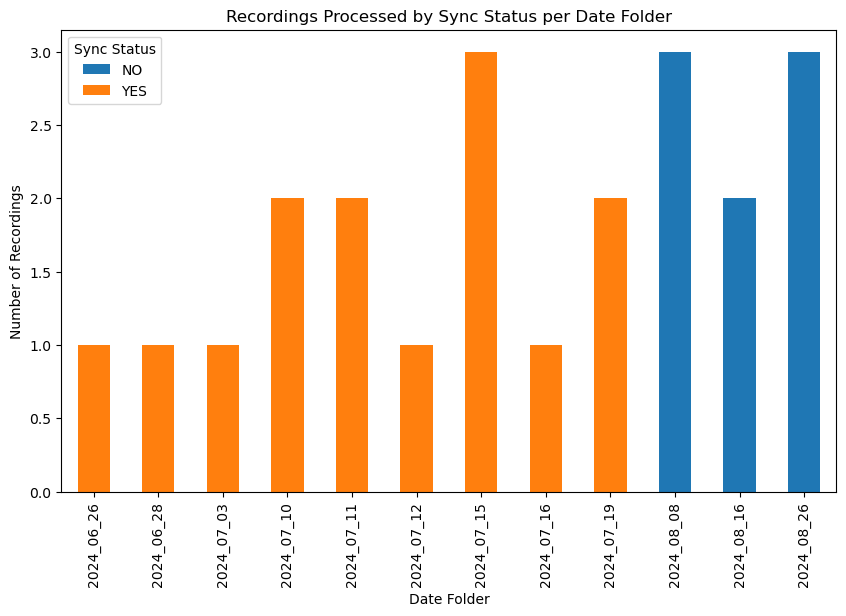

In [19]:
# import matplotlib.pyplot as plt

# # Count the number of recordings (rec_file) per date_folder and sync status
# rec_count = flat_df.groupby(['date_folder', 'sync']).size().unstack(fill_value=0)

# # Plot the counts
# rec_count.plot(kind='bar', stacked=True, figsize=(10, 6))
# plt.title("Recordings Processed by Sync Status per Date Folder")
# plt.xlabel("Date Folder")
# plt.ylabel("Number of Recordings")
# plt.legend(title="Sync Status")
# plt.show()
